In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
# set random seed for reproducibility
np.random.seed(12345)

x = np.arange(5,400,10)*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

# Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

In [3]:
# define the model/function to be fitted.
def model(x, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)

    @pm.deterministic(plot=False)
    def gauss(x=x, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x,f))
MDL.sample(20000, 10000, 1)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.8 sec

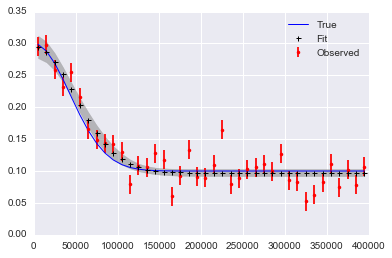

In [4]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

Plotting amp
Plotting ps
Plotting size


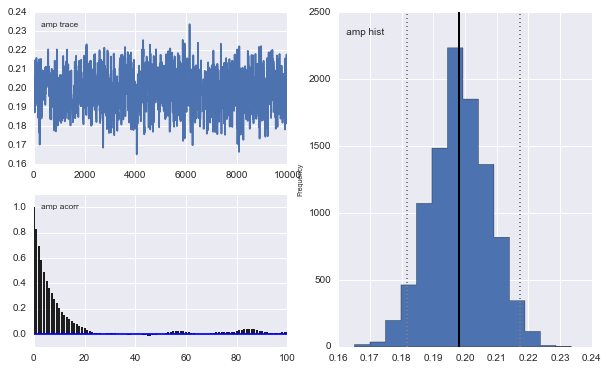

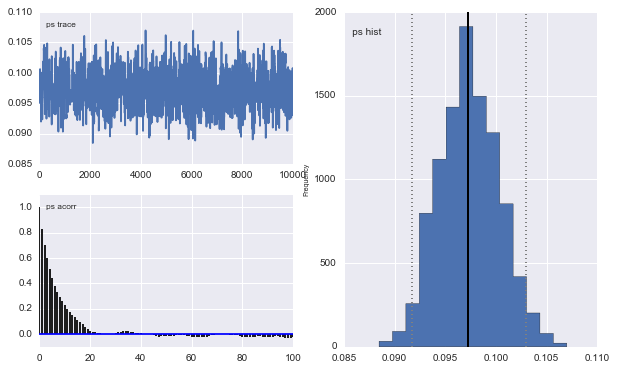

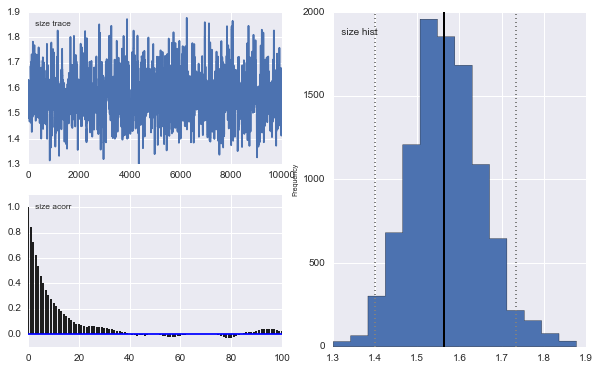

In [5]:
pm.Matplot.plot(MDL)

In [6]:
MDL.summary()


amp:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.198            0.009            0.0              [ 0.182  0.217]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.18             0.192           0.198          0.205         0.217
	

gauss:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.295            0.009            0.0              [ 0.278  0.313]
	0.287            0.008            0.0              [ 0.27   0.302]
	0.272            0.007            0.0              [ 0.258  0.285]
	0.251            0.006            0.0              [ 0.24   0.263]
	0.228            0.005            0.0              [ 0.217  0.239]
	0.204            0.006            0.0              [ 0.192  0.215

In [7]:
# add noise to observed x values
x_obs = pm.rnormal(mu=x, tau=(1e4)**-2)

# define the model/function to be fitted.
def model(x_obs, f): 
    amp = pm.Uniform('amp', 0.05, 0.4, value= 0.15)
    size = pm.Uniform('size', 0.5, 2.5, value= 1.0)
    ps = pm.Normal('ps', 0.13, 40, value=0.15)
    
    x_pred = pm.Normal('x', mu=x_obs, tau=(1e4)**-2) # this allows error in x_obs

    @pm.deterministic(plot=False)
    def gauss(x=x_pred, amp=amp, size=size, ps=ps):
        e = -1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.))
        return amp*np.exp(e)+ps
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, value=f, observed=True)
    return locals()

MDL = pm.MCMC(model(x_obs, f))
MDL.use_step_method(pm.AdaptiveMetropolis, MDL.x_pred) # use AdaptiveMetropolis to "learn" how to step
MDL.sample(200000, 100000, 10)  # run chain longer since there are more dimensions

 [-----------------100%-----------------] 200000 of 200000 complete in 78.7 sec

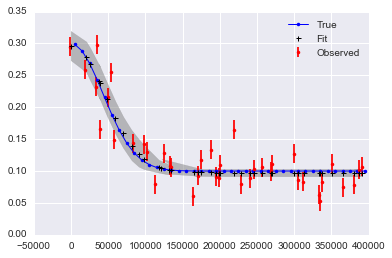

In [8]:
# extract and plot results
y_min = MDL.stats()['gauss']['quantiles'][2.5]
y_max = MDL.stats()['gauss']['quantiles'][97.5]
y_fit = MDL.stats()['gauss']['mean']
x_fit = MDL.x_pred.trace().mean(0)
plt.plot(x,f_true,'b', marker='.', ls='-', lw=1, label='True')
plt.errorbar(x_obs, f, yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x_fit, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

In [9]:
MDL.summary()


gauss:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.296            0.012            0.0              [ 0.273  0.319]
	0.279            0.012            0.0              [ 0.256  0.304]
	0.268            0.013            0.0              [ 0.242  0.293]
	0.238            0.013            0.0              [ 0.211  0.263]
	0.242            0.013            0.0              [ 0.215  0.267]
	0.213            0.013            0.0              [ 0.187  0.239]
	0.183            0.013            0.0              [ 0.158  0.208]
	0.16             0.012            0.0              [ 0.135  0.184]
	0.14             0.012            0.0              [ 0.116  0.163]
	0.127            0.011            0.0              [ 0.105  0.148]
	0.119            0.01             0.0              [ 0.102  0.138]
	0.106            0.005            0.0              [ 0.096  0.116]
	0.102            0.004            0.0